In [1]:
from keras.models import model_from_json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import tensorflow as tf
import keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [5]:
#batch_size = 2

model_file = 'VAE_3D_finalLoss__model.json'
weights_file = 'VAE_3D_finalLoss_weights.hdf5'

 # load json and create model
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
vae_model = model_from_json(loaded_model_json)

vae_model.load_weights(weights_file)

vae_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1, 28, 28, 28 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 28, 28, 28, 2 252         input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv3D)                  (None, 64, 14, 14, 1 14400       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv3D)                  (None, 64, 14, 14, 1 110656      conv2[0][0]                      
__________________________________________________________________________________________________
conv4 (Con

In [ ]:
vae.outputs

In [6]:
x_train_batch = np.load('../Data_handling/x_train_negativeOnly.npy')
y_train_batch = np.load('../Data_handling/y_train_negativeOnly.npy')

In [7]:
x_train_batch.shape

(2200, 1, 28, 28, 28)

In [8]:
x_nodule = x_train_batch[:2200]
y_nodule = y_train_batch[:2200] 



In [9]:
ineg = np.where(y_nodule == 0)
ipos = np.where(y_nodule == 1) 

In [10]:
x_nodule_neg = x_nodule[ineg]
x_nodule_pos = x_nodule[ipos]

In [11]:
x_nodule_neg.shape

(1741, 1, 28, 28, 28)

In [91]:
x_nodule_pos.shape

(450, 1, 28, 28, 28)

In [93]:
x_pred.shape

(450, 1, 28, 28, 28)

In [12]:
x_nodule_pos = x_nodule_pos[:450]
x_nodule_neg = x_nodule_neg[:450]

In [ ]:
x_nodule_neg_test = x_nodule_neg[-450:]

In [92]:
x_pred = vae_model.predict(x_nodule_neg, batch_size=25)

In [100]:
def plot_pred(element, rows, cols):
    #print('Number {}'.format(generated_images_label[element]))
    plt.figure(figsize=(10, 10))
    plt.figure(1)
    for idx in range(rows * cols):
        plt.subplot(rows, cols, idx + 1)
        plt.axis('off')
        plt.imshow(x_pred[element, 0, idx], cmap=plt.get_cmap('gray'))
    plt.show()

In [101]:
def plot_origi(element, rows, cols):
    #print('Number {}'.format(generated_images_label[element]))
    plt.figure(figsize=(10, 10))
    plt.figure(1)
    for idx in range(rows * cols):
        plt.subplot(rows, cols, idx + 1)
        plt.axis('off')
        plt.imshow(x_nodule_neg[element, 0, idx], cmap=plt.get_cmap('gray'))
    plt.show()

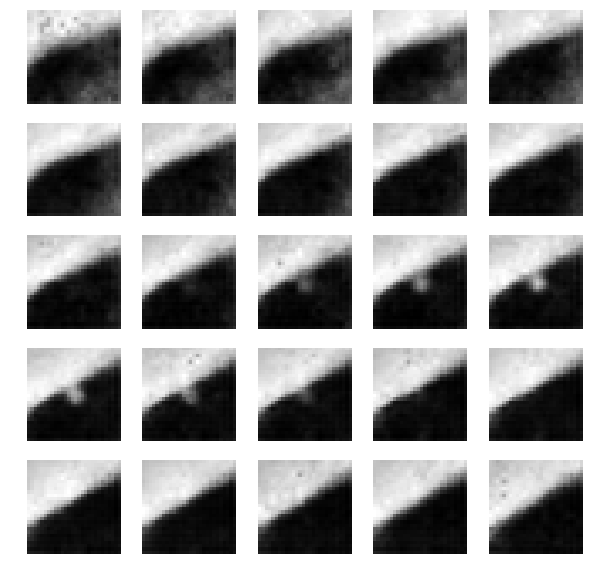

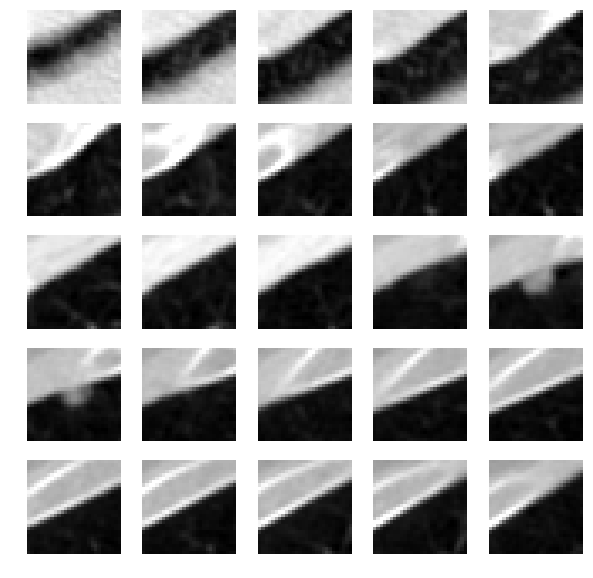

In [102]:
img = 400

plot_pred(img,5,5)
plot_origi(img,5,5)

In [ ]:
plot_origi(4,5,5)

## Analysis of loss

In [103]:
try:
    import cPickle as pickle
except ImportError:
    import pickle
import matplotlib.pyplot as plt

In [104]:
folder = 'VAE_3D_finalLoss_history.pkl'  
with open(r"{}".format(folder), "rb") as input_file:
    hist = pickle.load(input_file)

In [105]:
hist['train'].keys()

dict_keys(['kl_loss_f', 'mean_squared_error', 'reconstruction_error_f', 'loss'])

In [138]:
def plot_loss(folder):
    # load the loss data
    with open(r"{}".format(folder), "rb") as input_file:
        hist = pickle.load(input_file)

        # summarize history for loss
    plt.plot(hist['train']['kl_loss_f'][1:])
    #plt.plot(hit['train']['val_loss'])
    plt.title('Reconstruction Error')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()

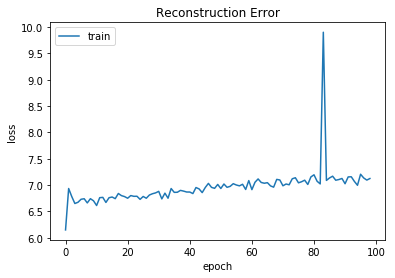

In [139]:
plot_loss(folder)

## Compiling and evaluating the model

In [13]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras import metrics
from keras.losses import mse
# keras imports
from keras.models import Model, Sequential
from keras.layers.merge import _Merge
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

K.set_image_data_format('channels_first')



## create model only with input and output z_mean and z_log_var

In [14]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 28
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 25
if K.image_data_format() == 'channels_first':
    original_img_size = (1, img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns, 1)
latent_dim = 10
intermediate_dim = 128
epsilon_std = 1.0
epochs = 100


x = Input(batch_shape=(None,) + original_img_size, name='input')
# x = Input(batch_shape=(None,) + original_img_size)
conv_1 = Conv3D(img_chns,
                kernel_size=(2, 2, 2),
                padding='same', activation='relu', name='conv1')(x)
conv_2 = Conv3D(filters,
                kernel_size=(2, 2, 2),
                padding='same', activation='relu',
                strides=(2, 2, 2), name='conv2')(conv_1)
conv_3 = Conv3D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1, name='conv3')(conv_2)
conv_4 = Conv3D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1, name='conv4')(conv_3)
flat = Flatten(name='flatten1')(conv_4) # change to conv to reduce the parameters nb
hidden = Dense(intermediate_dim, activation='relu', name='hiden1')(flat)

z_mean = Dense(latent_dim, name='z_mean')(hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden)



def sampling(args):
    #batch_size = 25
    #latent_dim = 10
    #epsilon_std = 1.0 cant save the model using variables inside this function
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(25, 10),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon #multiply 0.5 !!!!

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#Encoder
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu', name='decoder1')
decoder_upsample = Dense(filters * 14 * 14 * 14, activation='relu', name='decoder2')

if K.image_data_format() == 'channels_first':
    output_shape = (None, filters, 14, 14, 14)
else:
    output_shape = (None, 14, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:], name='decoderReshape1')
decoder_deconv_1 = UpSampling3D(size=(2, 2, 2), name='decoderUp1')
decoder_deconv_2 = UpSampling3D(size=(1, 1, 1), name='decoderUp2')
if K.image_data_format() == 'channels_first':
    output_shape = (None, filters, 29, 29, 29)
else:
    output_shape = (None, 29, 29, 29, filters)
decoder_deconv_3_upsamp = UpSampling3D(size=(1, 1, 1), name='decoderUp3')
decoder_mean_squash = Conv3D(1,
                             kernel_size=2,
                             padding='same',
                             activation='sigmoid', name='decoderConv1')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# definition of the losses as functions to be added in the compile - metrics of Keras
# definition of the lossekl_losss as functions to be added in the compile - metrics of Keras
def kl_loss_f(inputs,outputs):
        # D_KL(Q(z|X) || P(z|X))
    #z_mean, z_log_var = args
    kl_loss_f = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss_f


def reconstruction_error_f(inputs, outputs):
    # E[log P(X|z)]
    inputs = K.flatten(inputs)
    outputs = K.flatten(outputs)
    reconstruction_loss_f =  img_rows * img_rows * mse(inputs,outputs)
    #image_size * image_size * mse(inputs,outputs)
    return reconstruction_loss_f


# Loss to be optimized in the training

def total_loss(inputs, outputs):
    inputs = K.flatten(inputs)
    outputs = K.flatten(outputs)
    # log likelihood
    reconstruction_loss =  img_rows * img_rows * mse(inputs,outputs)
    #kl_loss_ = kl_loss(inputs,outputs)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    loss = K.mean(reconstruction_loss + kl_loss) #why is the mean?
    return loss

vae = Model(x, x_decoded_mean_squash)
vae.compile(loss=total_loss, optimizer='rmsprop', metrics=[mse, kl_loss_f,reconstruction_error_f])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1, 28, 28, 28 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 28, 28, 28, 2 252         input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv3D)                  (None, 64, 14, 14, 1 14400       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv3D)                  (None, 64, 14, 14, 1 110656      conv2[0][0]                      
__________________________________________________________________________________________________
conv4 (Con

## creating Encoder for z

In [110]:
encoder = Model(x, [z_mean, z_log_var])

In [ ]:
#encoder_1 = Model(x, z_mean)

In [111]:
encoder.load_weights(weights_file, by_name=True)


In [112]:
x_nodule_neg.shape

(450, 1, 28, 28, 28)

In [ ]:
#encoder.compile(loss=total_loss, optimizer='rmsprop', metrics=[mean_squared_error, kl_loss])

In [ ]:
encoder_predict_neg = encoder.predict(x_nodule_neg) #predict for non cancer
encoder_predict_pos = encoder.predict(x_nodule_pos) #predict for cancer 

In [113]:
vae.load_weights(weights_file)


## update: compute the likelihood over L samples by passing the same image as a whole mini_batch (mini_batch.size = L) 

In [24]:
x_train_neg_ = x_nodule_neg[:100]
x_train_pos_ = x_nodule_pos[:100]

In [25]:
L_datapoint_neg  = vae.evaluate(x_datapoint_neg, x_datapoint_neg, batch_size = 25)

100/100 [==============================] - 1s 8ms/step


In [26]:
L_datapoint_neg

[58.87547969818115,
 0.07508176565170288,
 0.011376768350601196,
 58.86410331726074]

In [27]:
#computing the score for all nodules 
#negative nodules 
l = 100 # number of repetition of the same nodule for creating a batch of it and compute the metrics l times
L_log_neg =[]
L_mse_neg = []
for i in range(x_train_neg_.shape[0]):
    x_datapoint_neg = np.vstack((x_train_neg_[[i]],)*l)
    L_datapoint_neg  = vae.evaluate(x_datapoint_neg, x_datapoint_neg,batch_size = 25)

    kl_loss_datapoint = L_datapoint_neg[2]
    reconstruction_error_datapoint = L_datapoint_neg[3]
    L_log_n = kl_loss_datapoint + reconstruction_error_datapoint
    L_log_neg_ = L_log_neg.append(L_log_n)
    L_mse_neg_ = L_mse_neg.append(L_datapoint_neg[1])

100/100 [==============================] - 1s 7ms/step


In [28]:
#computing the score for all nodules 
#positive nodules 
L_log_pos =[]
L_mse_pos = []
for i in range(x_train_pos_.shape[0]):
    x_datapoint_pos = np.vstack((x_train_pos_[[i]],)*l)
    L_datapoint_pos  = vae.evaluate(x_datapoint_pos, x_datapoint_pos,batch_size = 25)

    kl_loss_datapoint = L_datapoint_pos[2]
    reconstruction_error_datapoint = L_datapoint_pos[3]
    L_log_p = kl_loss_datapoint + reconstruction_error_datapoint
    L_log_pos_ = L_log_pos.append(L_log_p)
    L_mse_pos_ = L_mse_pos.append(L_datapoint_pos[1])
    

100/100 [==============================] - 1s 7ms/step


In [ ]:
kl_computed_manually_datapoint = encoder.predict(x_datapoint_neg, batch_size=25) #predict for negative
z_mean_datap = kl_computed_manually_datapoint[0]
z_log_var_datap = kl_computed_manually_datapoint[1]
kl_datap_man = - 0.5 * np.sum(1 + z_log_var_datap - np.square(z_mean_datap) - np.exp(z_log_var_datap))
kl_datap_man /=25
kl_datap_man

## Visualizing the loss

(array([42., 13., 47., 61., 66., 80., 72., 49., 17.,  3.]),
 array([ 36.55056867,  49.66758585,  62.78460304,  75.90162022,
         89.0186374 , 102.13565458, 115.25267177, 128.36968895,
        141.48670613, 154.60372331, 167.7207405 ]),
 <a list of 10 Patch objects>)

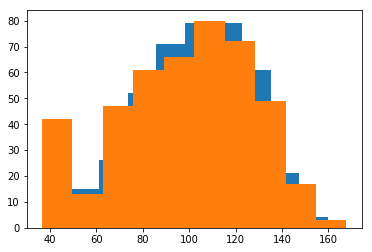

In [18]:
plt.hist(L_log_neg)
plt.hist(L_log_pos)

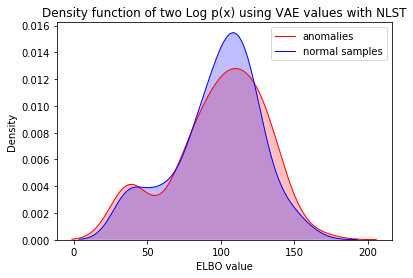

In [29]:
import seaborn as sns
plt.figure()
ax1 = sns.distplot(L_log_pos , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='anomalies',color="red")
ax2 = sns.distplot(L_log_neg , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='normal samples', color= "blue")



plt.title('Density function of two Log p(x) using VAE values with NLST')
plt.xlabel('ELBO value')
plt.ylabel('Density')
plt.legend()

In [30]:
y_true_neg = np.zeros([100,1])
y_true_pos = np.ones([100,1])
y_true = np.concatenate((y_true_neg, y_true_pos))

scores = np.concatenate((L_log_neg, L_log_pos))

In [31]:
np.save('x_train_likelihood_proper_vae', scores)
np.save('y_train_proper_vae', y_true)

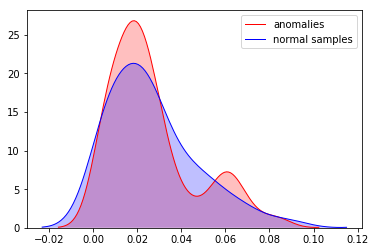

In [146]:

plt.figure()
ax1 = sns.distplot(L_mse_pos , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='anomalies',color="red")
ax2 = sns.distplot(L_mse_neg , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='normal samples', color= "blue")

In [ ]:
plt.hist(scores_neg)
plt.hist(scores_pos)

In [ ]:
import seaborn as sns
plt.figure()
ax1 = sns.distplot(L_log_pos , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='normal samples',color="red")
ax2 = sns.distplot(L_log_neg , hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade':True}, label='anomalies', color= "blue")



plt.title('Density function of two Log p(x) using VAE values')
plt.xlabel('ELBO value')
plt.ylabel('Density')
plt.legend()

In [ ]:
plt.hist([scores_neg, scores_pos])

In [ ]:
import seaborn as sns
sns.distplot(scores_neg , hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'shade':True} 
                 )

In [ ]:
sns.distplot(scores_pos , hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'shade':True} 
                 )

In [ ]:
import seaborn as sns
plt.figure()
ax1 = sns.distplot(scores_pos , hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade':True}, color="red")
ax2 = sns.distplot(scores_neg , hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade':True}, color= "blue")

In [ ]:
sns.set(style="white", color_codes=True)
sns.jointplot(x=scores_neg, y=scores_pos, kind='kde', color="skyblue")



## AUROC Anomaly

In [ ]:
import sklearn.metrics as skl
y_true_neg = np.zeros([450,1])
y_true_pos = np.ones([450,1])
y_true = np.concatenate((y_true_neg, y_true_pos))

y_pred = np.concatenate((scores_neg, scores_pos))

fpr, tpr, thresholds = skl.roc_curve(y_true, y_pred, pos_label=0)
roc_auc = skl.auc(fpr, tpr)


In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
np.save('x_train_likelihood', y_pred)
np.save('y_train', y_true)

In [ ]:
v1 = np.load('x_train_likelihood.npy')
v2 = np.load('y_train.npy')

In [ ]:
v2.shape